In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as tfk
import tensorflow_datasets as tfds
from tensorflow.data.experimental import sample_from_datasets
from keras.layers import Activation, Dense, Dropout

tfkl = tfk.layers

**Preprocessing**

As typical, we'll start with the MNIST data. Recall from last time, we have to do some transformations and preprocessing on these images.

In [4]:
data, info = tfds.load('mnist', with_info=True)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [5]:
preprocess = lambda d: (tf.cast(d["image"], tf.float32)/255, tf.one_hot(d["label"], depth=10))

ds_train = data["train"].map(preprocess).cache().batch(32)
ds_test = data["test"].map(preprocess).cache().batch(32)

In [6]:
img_shape = info.features['image'].shape

In [7]:
img_shape

(28, 28, 1)

**CNNs in TF Keras**

We'll use the Sequential class rely on new layer types that correspond to concepts we covered in lecture: Conv2D, AvgPool2D, MaxPool2D. 

Details such as kernel size, padding, strides and so on must be specified as args to these classes, where appropriate.

In [8]:
model = tfk.Sequential()
model.add(tfkl.Conv2D(filters = 1, kernel_size=(3,3), strides=(1,1), 
                      padding="valid", activation='relu', input_shape=(28, 28, 1)))
model.add(tfkl.MaxPool2D(pool_size=(4,4)))
model.add(tfkl.Flatten())
model.add(tfkl.Dense(10, activation='softmax'))

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 1)         10        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 6, 6, 1)           0         
_________________________________________________________________
flatten (Flatten)            (None, 36)                0         
_________________________________________________________________
dense (Dense)                (None, 10)                370       
Total params: 380
Trainable params: 380
Non-trainable params: 0
_________________________________________________________________


In [10]:
model.compile(
    optimizer=tfk.optimizers.RMSprop(),
    loss=tfk.losses.CategoricalCrossentropy(),
)

results = model.fit(ds_train, steps_per_epoch=20, epochs=20, validation_data=ds_test)

Epoch 1/20
20/20 [==============================] - 3s 142ms/step - loss: 2.4758 - val_loss: 2.4410
Epoch 2/20
20/20 [==============================] - 2s 77ms/step - loss: 2.4029 - val_loss: 2.3793
Epoch 3/20
20/20 [==============================] - 2s 76ms/step - loss: 2.3707 - val_loss: 2.3416
Epoch 4/20
20/20 [==============================] - 2s 76ms/step - loss: 2.3322 - val_loss: 2.3099
Epoch 5/20
20/20 [==============================] - 2s 78ms/step - loss: 2.3034 - val_loss: 2.2870
Epoch 6/20
20/20 [==============================] - 2s 77ms/step - loss: 2.2976 - val_loss: 2.2679
Epoch 7/20
20/20 [==============================] - 2s 77ms/step - loss: 2.2725 - val_loss: 2.2462
Epoch 8/20
20/20 [==============================] - 2s 77ms/step - loss: 2.2480 - val_loss: 2.2221
Epoch 9/20
20/20 [==============================] - 2s 76ms/step - loss: 2.2170 - val_loss: 2.1925
Epoch 10/20
20/20 [==============================] - 2s 77ms/step - loss: 2.1901 - val_loss: 2.1607
Epoch 11

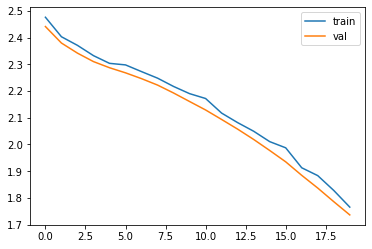

In [11]:
plt.plot(results.history["loss"])
plt.plot(results.history["val_loss"])
plt.legend(labels=["train", "val"])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  """Entry point for launching an IPython kernel.


Text(0.5, 0, 'Probability')

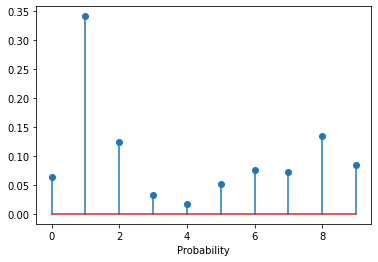

In [12]:
plt.stem(model.predict(ds_test.take(1))[9, :])
plt.xlabel("Digit")
plt.xlabel("Probability")

Which architectural hyperparameters might we change in the above?



**Exercise - Deep CNN**

Build and fit your own CNN model with 3 convolutional **modules**, where each one contains:
  * kernel convolution 
    * you pick number of kernels
    * you pick kernel shape/size
    * you pick activation
  * pooling
  * dropout

We'll use the Fashion MNIST dataset, a low-res collection of images of clothing.

In [13]:
train, test = tf.keras.datasets.fashion_mnist.load_data()

images, labels = train
images = images/255.0
images = images[:, :, :, np.newaxis]
labels = tf.one_hot(labels.astype(np.int32),10)

# optional - TF Datasets objects
fmnist_train_ds = tf.data.Dataset.from_tensor_slices((images, labels))
fmnist_train_ds = fmnist_train_ds.shuffle(5000).batch(32)

images1, labels1 = test
images1 = images1/255.0
images1 = images1[:, :, :, np.newaxis]
labels1 = tf.one_hot(labels1.astype(np.int32),10)

fmnist_test_ds = tf.data.Dataset.from_tensor_slices((images1, labels1))
fmnist_test_ds = fmnist_test_ds.shuffle(5000).batch(32)


4423680/4422102 [==============================] - 0s 0us/step


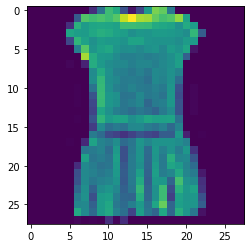

In [14]:
plt.imshow(images[3, :, :, :].squeeze())

In [15]:
model = tfk.Sequential()

# 1
model.add(tfkl.Conv2D(filters = 1, kernel_size= 2, strides= 2, 
                      padding="valid", activation='relu', input_shape=(28, 28, 1)))
model.add(tfkl.MaxPool2D(pool_size=(2)))
model.add(Dropout(0.2))

# 2
model.add(tfkl.Conv2D(filters = 16, kernel_size= 2, strides= 1, 
                      padding="valid", activation='relu'))
model.add(tfkl.MaxPool2D(pool_size=(2)))
model.add(Dropout(0.2))

# 3
model.add(tfkl.Conv2D(filters = 8, kernel_size= 2, strides= 1, 
                      padding="valid", activation='relu'))
model.add(tfkl.MaxPool2D(pool_size=(2)))
model.add(Dropout(0.2))

# Flatten
model.add(tfkl.GlobalMaxPool2D())
model.add(tfkl.Dense(10, activation='softmax'))

In [16]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 1)         5         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 1)           0         
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 1)           0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 6, 16)          80        
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 16)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 3, 3, 16)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 2, 2, 8)          

In [17]:
model.compile(
    optimizer=tfk.optimizers.RMSprop(),
    loss=tfk.losses.CategoricalCrossentropy(),
)

results = model.fit(fmnist_train_ds,batch_size=32,steps_per_epoch=20, epochs=20,validation_data=fmnist_test_ds)

Epoch 1/20
20/20 [==============================] - 1s 46ms/step - loss: 2.3566 - val_loss: 2.2772
Epoch 2/20
20/20 [==============================] - 1s 44ms/step - loss: 2.2915 - val_loss: 2.2613
Epoch 3/20
20/20 [==============================] - 1s 41ms/step - loss: 2.2839 - val_loss: 2.2584
Epoch 4/20
20/20 [==============================] - 1s 42ms/step - loss: 2.2589 - val_loss: 2.2436
Epoch 5/20
20/20 [==============================] - 1s 42ms/step - loss: 2.2425 - val_loss: 2.2254
Epoch 6/20
20/20 [==============================] - 1s 42ms/step - loss: 2.2127 - val_loss: 2.1962
Epoch 7/20
20/20 [==============================] - 1s 43ms/step - loss: 2.2223 - val_loss: 2.1748
Epoch 8/20
20/20 [==============================] - 1s 43ms/step - loss: 2.1546 - val_loss: 2.1338
Epoch 9/20
20/20 [==============================] - 1s 41ms/step - loss: 2.1180 - val_loss: 2.0989
Epoch 10/20
20/20 [==============================] - 1s 41ms/step - loss: 2.1067 - val_loss: 2.0768
Epoch 11/

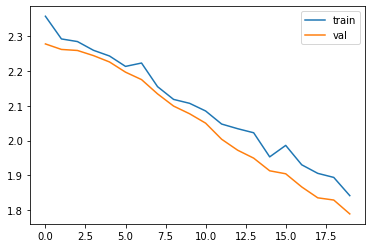

In [18]:
plt.plot(results.history["loss"])
plt.plot(results.history["val_loss"])
plt.legend(labels=["train", "val"])


#|**Exercise - Transfer Learning**



In [19]:
data, info = tfds.load('rock_paper_scissors', with_info=True)
train_data = data["train"].map(lambda x: (tf.cast(x["image"], tf.float32) / 255., tf.one_hot(x["label"], depth=3))).batch(16)
test_data = data["train"].map(lambda x: (tf.cast(x["image"], tf.float32) / 255., tf.one_hot(x["label"], depth=3))).batch(16)

Shuffling and writing examples to /root/tensorflow_datasets/rock_paper_scissors/3.0.0.incompleteNLZYG6/rock_paper_scissors-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/rock_paper_scissors/3.0.0.incompleteNLZYG6/rock_paper_scissors-test.tfrecord


Dataset rock_paper_scissors downloaded and prepared to /root/tensorflow_datasets/rock_paper_scissors/3.0.0. Subsequent calls will reuse this data.


In [20]:
info.features['image'].shape

(300, 300, 3)

,image,label
0,,2 (scissors)
1,,2 (scissors)
2,,0 (rock)
3,,1 (paper)
4,,0 (rock)
5,,1 (paper)
6,,2 (scissors)
7,,1 (paper)
8,,2 (scissors)
9,,2 (scissors)

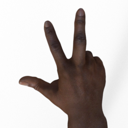
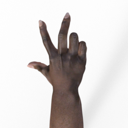
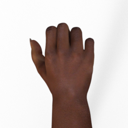
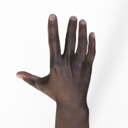
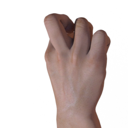
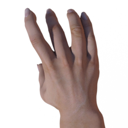
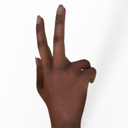
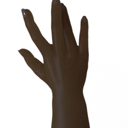
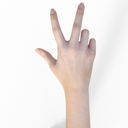
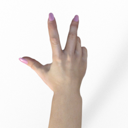

In [21]:
tfds.as_dataframe(data["train"].take(10), info)

# Exercise

1. Build a deep CNN model and train it for this binary classification task. Fit the model using the small dataset of 500 samples, *train_data*.

What accuracy can your model acheive on the training data?

In [22]:
rocks_train = data["train"].take(500)
rocks_train = rocks_train.map(lambda x: (tf.cast(x["image"], tf.float32) / 255.,tf.one_hot(x["label"], depth=3))).batch(32)

In [23]:
#Seperating labels and images
train_images, train_labels = next(iter(rocks_train))
test_images, test_labels = next(iter(test_data))

In [24]:
train_images.shape

TensorShape([32, 300, 300, 3])

In [25]:
 model = tfk.Sequential()

 model.add(tfkl.Conv2D(32, 3, padding='same', activation='relu',kernel_initializer='he_uniform', input_shape = [300,300, 3]))
 model.add(tfkl.MaxPooling2D(2))

 model.add(tfkl.Conv2D(32, 3, padding='same', kernel_initializer='he_uniform', activation='relu'))
 model.add(tfkl.MaxPooling2D(2))

 model.add(tfkl.Conv2D(64, 3, padding='same', kernel_initializer='he_uniform',activation='relu'))
 model.add(tfkl.MaxPooling2D(2))

 model.add(tfkl.Conv2D(128, 3, padding='same', kernel_initializer='he_uniform',activation='relu'))
 model.add(tfkl.MaxPooling2D(2))

 model.add(tfkl.Flatten())
 model.add(tfkl.Dense(128, kernel_initializer='he_uniform',activation = 'relu'))
 model.add(tfkl.Dense(3, activation = 'softmax'))

In [26]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 300, 300, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 150, 150, 32)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 150, 150, 32)      9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 37, 37, 128)      

In [27]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1,  horizontal_flip=True)
it_gen = datagen.flow(train_images, train_labels, batch_size=32)

In [28]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


steps = int(train_images.shape[0] / 32)
results = model.fit(it_gen,epochs = 20,steps_per_epoch=steps, validation_data = (test_images, test_labels))

Epoch 1/20
1/1 [==============================] - 1s 702ms/step - loss: 1.4285 - accuracy: 0.3125 - val_loss: 28.4388 - val_accuracy: 0.1250
Epoch 2/20
1/1 [==============================] - 1s 578ms/step - loss: 21.2398 - accuracy: 0.2500 - val_loss: 29.4340 - val_accuracy: 0.5000
Epoch 3/20
1/1 [==============================] - 1s 573ms/step - loss: 28.2659 - accuracy: 0.4688 - val_loss: 12.7298 - val_accuracy: 0.5000
Epoch 4/20
1/1 [==============================] - 1s 567ms/step - loss: 12.8575 - accuracy: 0.4688 - val_loss: 3.3379 - val_accuracy: 0.5000
Epoch 5/20
1/1 [==============================] - 1s 567ms/step - loss: 3.5946 - accuracy: 0.4688 - val_loss: 1.3296 - val_accuracy: 0.3750
Epoch 6/20
1/1 [==============================] - 1s 573ms/step - loss: 1.4573 - accuracy: 0.2812 - val_loss: 1.8445 - val_accuracy: 0.3750
Epoch 7/20
1/1 [==============================] - 1s 567ms/step - loss: 1.7938 - accuracy: 0.2812 - val_loss: 1.6147 - val_accuracy: 0.1875
Epoch 8/20
1/1

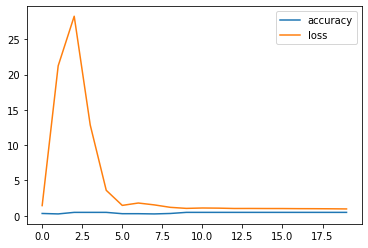

In [29]:
plt.plot(results.history["accuracy"])
plt.plot(results.history["loss"])
plt.legend(labels=["accuracy", "loss"])

 2. Now use transfer learning by incorporating the pretrained VGG16 model.

In [30]:
from tensorflow.keras.applications import VGG16

In [31]:
conv_base = VGG16(weights="imagenet",include_top=False,input_shape=(300,300,3))

58892288/58889256 [==============================] - 0s 0us/step


In [32]:
model = tfk.Sequential()

model.add(conv_base)

for layer in model.layers:
    layer.trainable = False

model.add(tfkl.Flatten())
model.add(tfkl.Dense(3, activation = 'softmax'))

In [33]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 9, 9, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 41472)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 124419    
Total params: 14,839,107
Trainable params: 124,419
Non-trainable params: 14,714,688
_________________________________________________________________


In [34]:
datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1,  horizontal_flip=True)
it_gen = datagen.flow(train_images, train_labels, batch_size=32)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


steps = int(train_images.shape[0] / 32)
results = model.fit(it_gen,epochs = 20,steps_per_epoch=steps, validation_data = (test_images, test_labels))

Epoch 1/20
1/1 [==============================] - 15s 15s/step - loss: 1.3830 - accuracy: 0.4688 - val_loss: 4.7187 - val_accuracy: 0.3750
Epoch 2/20
1/1 [==============================] - 14s 14s/step - loss: 4.6660 - accuracy: 0.3750 - val_loss: 3.7156 - val_accuracy: 0.1875
Epoch 3/20
1/1 [==============================] - 14s 14s/step - loss: 3.6702 - accuracy: 0.2500 - val_loss: 0.9161 - val_accuracy: 0.4375
Epoch 4/20
1/1 [==============================] - 14s 14s/step - loss: 1.0920 - accuracy: 0.4688 - val_loss: 1.4988 - val_accuracy: 0.5000
Epoch 5/20
1/1 [==============================] - 14s 14s/step - loss: 1.7173 - accuracy: 0.4688 - val_loss: 2.1354 - val_accuracy: 0.5000
Epoch 6/20
1/1 [==============================] - 14s 14s/step - loss: 2.6082 - accuracy: 0.4688 - val_loss: 1.4297 - val_accuracy: 0.5000
Epoch 7/20
1/1 [==============================] - 15s 15s/step - loss: 1.8087 - accuracy: 0.4688 - val_loss: 0.4928 - val_accuracy: 0.8750
Epoch 8/20
1/1 [===========

Build a Sequential model, using our VGG16 base. Make sure the freeze the weights of the convolutional backbone, but leave the remainder of the network weights as learnable. Fit this model and compare the overall accuracy as well as the loss curves (efficiency).


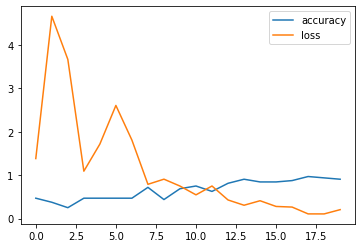

In [35]:
plt.plot(results.history["accuracy"])
plt.plot(results.history["loss"])
plt.legend(labels=["accuracy", "loss"])